# **Importing Libraries**

In [1]:
# Importing necessary libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
from collections import defaultdict
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score
from transformers import  Trainer, TrainingArguments
from datasets import Dataset
!pip install transformers
!pip install --upgrade jax jaxlib
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW  # Corrected import
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.8.2, so it will not be used.
  warnings.warn(


# Data Set loading and Basic Information

In [2]:
df = pd.read_csv('spamdataset.csv')
# Basic dataset information
df.info()

# Checking for missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5971 entries, 0 to 5970
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   LABEL   5971 non-null   object
 1   TEXT    5971 non-null   object
 2   URL     5971 non-null   object
 3   EMAIL   5971 non-null   object
 4   PHONE   5971 non-null   object
dtypes: object(5)
memory usage: 233.4+ KB


,0
LABEL,0
TEXT,0
URL,0
EMAIL,0
PHONE,0


# Label Distribution

/tmp/ipython-input-3142601865.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='Set1')


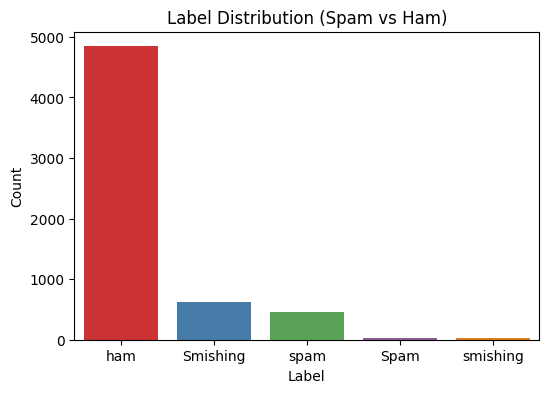

In [3]:
# Checking the distribution of spam vs ham
label_distribution = df['LABEL'].value_counts()

# Plotting this label distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='Set1')
plt.title('Label Distribution (Spam vs Ham)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


# Data Set Cleaning and Resolve problem in above graph

In [4]:
# Standardizing  the 'LABEL' column by converting all values to lowercase
df['LABEL'] = df['LABEL'].str.lower()

# Saving the cleaned dataset to a new CSV file
df.to_csv('cleaned_spamdataset.csv', index=False)

/tmp/ipython-input-3142601865.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='Set1')


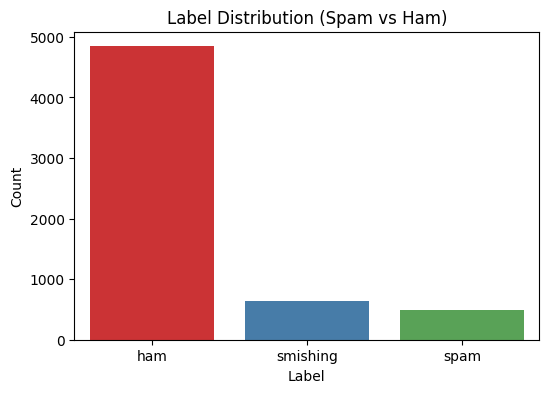

In [5]:
# Checking the distribution of spam vs ham
label_distribution = df['LABEL'].value_counts()

# Plotting this label distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='Set1')
plt.title('Label Distribution (Spam vs Ham)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


# Data Analysis

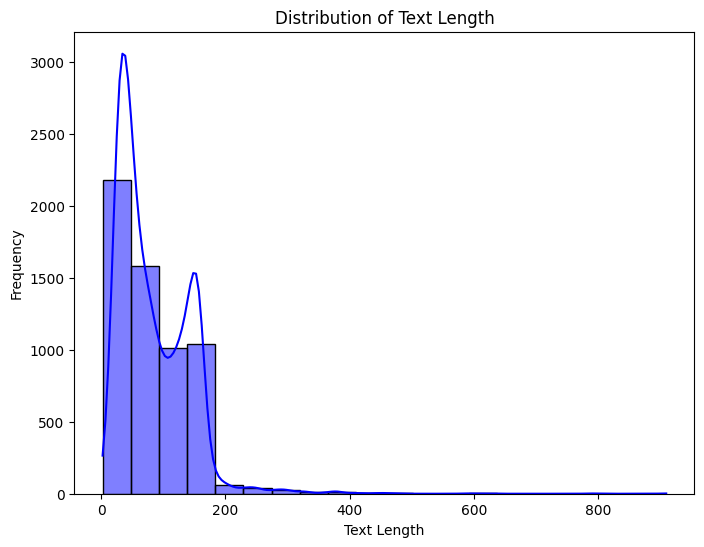

In [6]:
# Basic analysis of the text column
df['TEXT_LENGTH'] = df['TEXT'].apply(len)

# This is for Summary statistics of text length
df['TEXT_LENGTH'].describe()

# Plotting the distribution of text lengths
plt.figure(figsize=(8, 6))
sns.histplot(df['TEXT_LENGTH'], kde=True, color='blue', bins=20)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()



URL Count:
URL
No     5764
yes     207

Email Count:
EMAIL
No     5952
yes      19

Phone Count:
PHONE
No     5127
yes     844



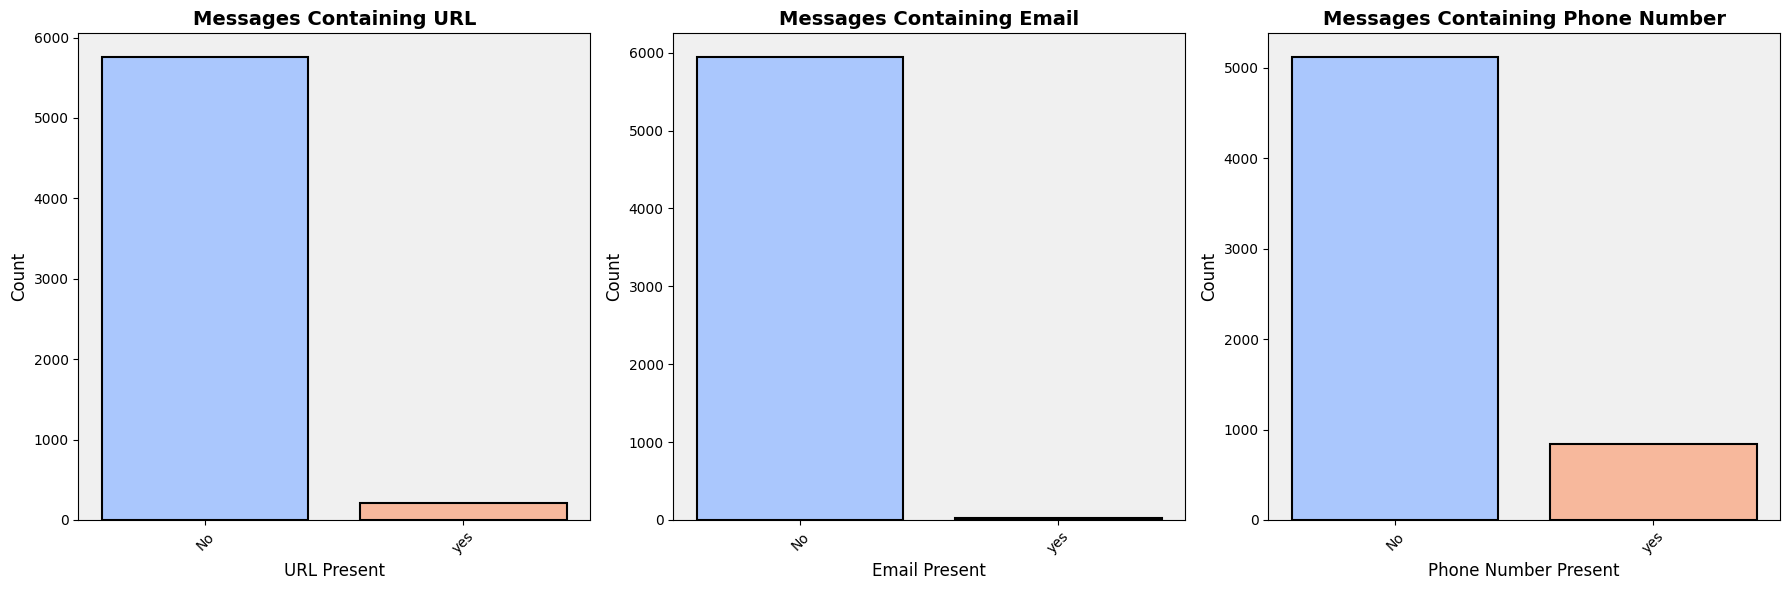

In [7]:
# Counting the occurrences of URLs, Emails, and Phone Numbers
url_count = df['URL'].value_counts()
email_count = df['EMAIL'].value_counts()
phone_count = df['PHONE'].value_counts()

# Displaying the counts in a professional format
print("\nURL Count:")
print(url_count.to_string(), end="\n\n")

print("Email Count:")
print(email_count.to_string(), end="\n\n")

print("Phone Count:")
print(phone_count.to_string(), end="\n\n")

# Creating 3D-like bar plots with a professional style
fig, ax = plt.subplots(1, 3, figsize=(18, 6))


ax[0].bar(url_count.index, url_count.values, color=sns.color_palette("coolwarm", len(url_count.index)))
ax[0].set_title('Messages Containing URL', fontsize=14, fontweight='bold')
ax[0].set_xlabel('URL Present', fontsize=12, fontweight='light')
ax[0].set_ylabel('Count', fontsize=12, fontweight='light')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_facecolor('whitesmoke')

ax[1].bar(email_count.index, email_count.values, color=sns.color_palette("coolwarm", len(email_count.index)))
ax[1].set_title('Messages Containing Email', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Email Present', fontsize=12, fontweight='light')
ax[1].set_ylabel('Count', fontsize=12, fontweight='light')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_facecolor('whitesmoke')


ax[2].bar(phone_count.index, phone_count.values, color=sns.color_palette("coolwarm", len(phone_count.index)))
ax[2].set_title('Messages Containing Phone Number', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Phone Number Present', fontsize=12, fontweight='light')
ax[2].set_ylabel('Count', fontsize=12, fontweight='light')
ax[2].tick_params(axis='x', rotation=45)
ax[2].set_facecolor('whitesmoke')


for axis in ax:
    for bar in axis.patches:
        bar.set_edgecolor('black')
        bar.set_linewidth(1.5)
    axis.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


# Wordcloud for Spam (Smishing) vs Non-Spam (Ham) Messag

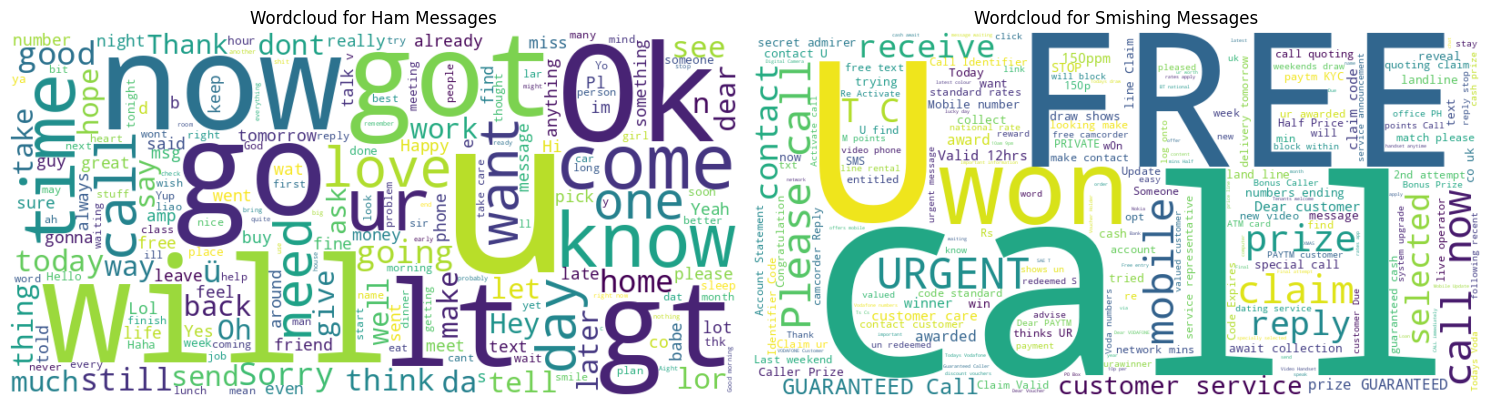

In [8]:
# Loading dataset
dataset = df

# Wordcloud for spam messages (Smishing) vs non-spam (ham)
ham_messages = dataset[dataset['LABEL'] == 'ham']['TEXT']
spam_messages = dataset[dataset['LABEL'] == 'smishing']['TEXT']

# Generating WordClouds
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ham_messages))
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_messages))

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(ham_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Wordcloud for Ham Messages')

ax[1].imshow(spam_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Wordcloud for Smishing Messages')

plt.tight_layout()
plt.show()


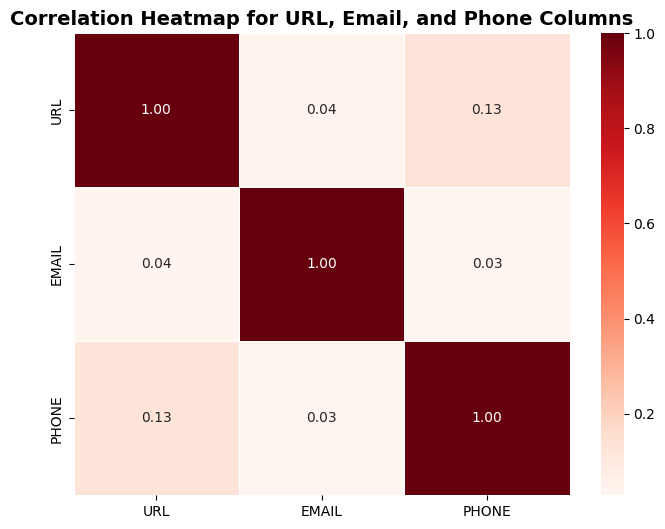

In [9]:
dataset = pd.read_csv('spamdataset.csv')

#Heatmap showing the correlation between numerical features (URL, EMAIL, PHONE) - As binary features
# First, we are converting URL, EMAIL, and PHONE to binary (0 for No, 1 for Yes)
dataset['URL'] = dataset['URL'].apply(lambda x: 0 if x == 'No' else 1)
dataset['EMAIL'] = dataset['EMAIL'].apply(lambda x: 0 if x == 'No' else 1)
dataset['PHONE'] = dataset['PHONE'].apply(lambda x: 0 if x == 'No' else 1)

# Correlation matrix for binary features
correlation_matrix = dataset[['URL', 'EMAIL', 'PHONE']].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for URL, Email, and Phone Columns', fontsize=14, fontweight='bold')
plt.show()


# BERT Implementation


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Loss: 0.0784, Accuracy: 0.9797
Epoch 2/5 - Loss: 0.0195, Accuracy: 0.9952
Epoch 3/5 - Loss: 0.0075, Accuracy: 0.9983
Epoch 4/5 - Loss: 0.0014, Accuracy: 0.9998
Epoch 5/5 - Loss: 0.0008, Accuracy: 1.0000
Test Accuracy: 0.9933

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       969
           1       1.00      0.96      0.98       226

    accuracy                           0.99      1195
   macro avg       1.00      0.98      0.99      1195
weighted avg       0.99      0.99      0.99      1195



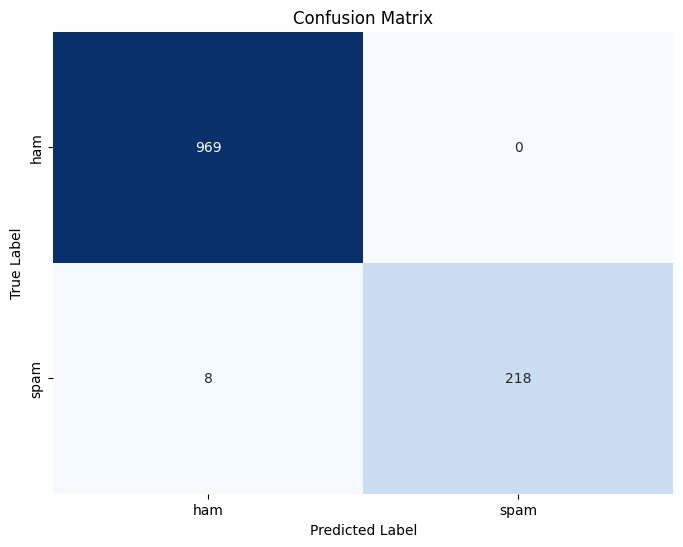

In [10]:
# Loading the cleaned dataset
df = pd.read_csv('cleaned_spamdataset.csv')

# Preprocessing dataset
df['LABEL'] = df['LABEL'].apply(lambda x: 0 if x == 'ham' else 1)  # Converting 'ham' to 0 and 'spam'/'Smishing' to 1

# Splitting dataset into training and testing sets (80% train, 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(df['TEXT'], df['LABEL'], test_size=0.2, stratify=df['LABEL'], random_state=42)

# Loading BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenizastion the texts
max_length = 128  # Limit sequence length
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length)

# Creating TensorDatasets for training and testing
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                               torch.tensor(train_encodings['attention_mask']),
                               torch.tensor(train_labels.tolist()))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                              torch.tensor(test_encodings['attention_mask']),
                              torch.tensor(test_labels.tolist()))

# Creating DataLoader for batching
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Moving the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Setting up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 5  # Setting the number of epochs for training
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop
for epoch in range(epochs):
    model.train()  # Setting model to training mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        # Moving batch data to device (GPU or CPU)
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch


        optimizer.zero_grad()


        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits


        loss.backward()
        optimizer.step()
        scheduler.step()

        # Calculating loss and accuracy
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == labels).item()
        total_predictions += len(labels)

    # Calculating average loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluation
model.eval()  # Setting model to evaluation mode
predictions, true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(labels.tolist())

# Calculatting accuracy on the test set
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Printting the classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

# Plotting confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Hyperparameter Tunning

In [12]:
import random

# Defining hyperparameter search space
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [16, 32]
epochs = 3  # Number of epochs to train (this can also be tuned, but we'll keep it fixed for now)

# Performing Random Search
best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with Learning Rate: {lr}, Batch Size: {batch_size}")

        # Reinitializing the model and optimizer with new parameters
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=lr)
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Training the model with the current hyperparameters
        for epoch in range(epochs):
            model.train()  # Setting model to training mode
            total_loss = 0
            correct_predictions = 0
            total_predictions = 0

            for batch in DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size):
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, labels = batch

                optimizer.zero_grad()

                # Forward pass
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                loss.backward()
                optimizer.step()
                scheduler.step()

                # Calculateingaccuracy
                total_loss += loss.item()
                predictions = torch.argmax(logits, dim=1)
                correct_predictions += torch.sum(predictions == labels).item()
                total_predictions += len(labels)

        # Evaluating the model
        model.eval()
        predictions, true_labels = [], []
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(labels.tolist())

        # Calculating validation accuracy
        val_accuracy = accuracy_score(true_labels, predictions)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Tracking the best parameters based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f"Best Hyperparameters: {best_params}")


Training with Learning Rate: 1e-05, Batch Size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.9950
Training with Learning Rate: 1e-05, Batch Size: 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.9925
Training with Learning Rate: 2e-05, Batch Size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.9941
Training with Learning Rate: 2e-05, Batch Size: 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.9925
Training with Learning Rate: 3e-05, Batch Size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.9933
Training with Learning Rate: 3e-05, Batch Size: 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.9900
Best Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 16}
